# Kaggle Competition: Detect Fraud from Customer Transactions

In this project, we analyze a large scale dataset released by IEEE Computational Intelligence Society (IEEE-CIS) to detect fraud in customer transactions. By improving the accuracy of detecting fraud in credit card transactions, we can help millions of customers to shop safely and millions of business to reduce loss and increase revenue. The dataset consists of nearly 600,000 transactions with nearly 400 features. Details about the dataset and its documentation can be found on [Kaggle](https://www.kaggle.com/c/ieee-fraud-detection/).

First, we load the libraries we are going to use and create a path to the data files.

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics
from sklearn.metrics import roc_auc_score

The performance metric used in this competition is the ROC AUC score. We make sure the fastai library v0.7 is installed by checking the attribute `__version__`. Only fastai v1 and above have this attribute.

In [3]:
import fastai
fastai.__version__

AttributeError: module 'fastai' has no attribute '__version__'

In [4]:
PATH = "data_IEEE/"

In [5]:
!ls {PATH}

sample_submission.csv.zip  test_transaction.csv      train_identity.csv.zip
test_identity.csv	   test_transaction.csv.zip  train_transaction.csv
test_identity.csv.zip	   train_identity.csv	     train_transaction.csv.zip


# Data Exploration

In this section, we read in data files and explore their columns. Input data is in 2 separate files.

In [6]:
train_trans = pd.read_csv(f'{PATH}train_transaction.csv')

In [7]:
train_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 1.7+ GB


In [8]:
train_trans.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=394)

In [9]:
train_trans.TransactionDT.head(10)

0    86400
1    86401
2    86469
3    86499
4    86506
5    86510
6    86522
7    86529
8    86535
9    86536
Name: TransactionDT, dtype: int64

A first look at the data tells us that the training data has 590,540 rows and 394 columns. `TransactionDT` is a timedelta field and is sorted in ascending order. Documentation said that `D1`-`D15` are also timedelta columns.

In [10]:
train_trans.filter(regex='^D',axis=1).head()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0
1,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
2,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0
3,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
train_id = pd.read_csv(f'{PATH}train_identity.csv')

In [12]:
train_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
TransactionID    144233 non-null int64
id_01            144233 non-null float64
id_02            140872 non-null float64
id_03            66324 non-null float64
id_04            66324 non-null float64
id_05            136865 non-null float64
id_06            136865 non-null float64
id_07            5155 non-null float64
id_08            5155 non-null float64
id_09            74926 non-null float64
id_10            74926 non-null float64
id_11            140978 non-null float64
id_12            144233 non-null object
id_13            127320 non-null float64
id_14            80044 non-null float64
id_15            140985 non-null object
id_16            129340 non-null object
id_17            139369 non-null float64
id_18            45113 non-null float64
id_19            139318 non-null float64
id_20            139261 non-null float64
id_21            5159 non-null float64
id_2

The second training data files has 144,233 rows and 41 columns. We read in the test data.

In [13]:
test_trans = pd.read_csv(f'{PATH}test_transaction.csv')
test_id = pd.read_csv(f'{PATH}test_identity.csv')

# Cleaning Data

First, we extract particular date fields from the timedelta columns.

In [10]:
add_datepart(train_trans, 'TransactionDT')
add_datepart(test_trans, 'TransactionDT')

In [19]:
for i in range(1,16):
    col_name = 'D' + str(i)
    add_datepart(train_trans, col_name)
    add_datepart(test_trans, col_name)

Then, we combine the two input files into one.

In [20]:
train_merged = pd.merge(left=train_trans, right=train_id, on='TransactionID',how='left')

In [21]:
test_merged = pd.merge(left=test_trans, right=test_id, on='TransactionID',how='left')

In [22]:
train_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 614 entries, TransactionID to DeviceInfo
dtypes: bool(90), float64(474), int64(19), object(31)
memory usage: 2.4+ GB


After combining, the dataset has 590,540 rows, 446 columns. Next, we change string columns to categorical types.

In [23]:
train_cats(train_merged)

In [24]:
apply_cats(df=test_merged, trn=train_merged)

Store the processed data for fast future deployment.

In [25]:
os.makedirs('tmp', exist_ok=True)
train_merged.to_feather('tmp/IEEE-train-merged2')

In [26]:
test_merged.to_feather('tmp/IEEE-test-merged2')

# Returning to Work

From the second time working with the notebook, we can just load the cleaned data and save some time.

In [4]:
train_merged = pd.read_feather('tmp/IEEE-train-merged2')

In [5]:
train_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 614 entries, TransactionID to DeviceInfo
dtypes: bool(90), category(31), float64(474), int64(19)
memory usage: 2.2 GB


In [5]:
train_merged.filter(regex='^[Tt]ransaction',axis=1).head()

,TransactionID,TransactionAmt,TransactionDTYear,TransactionDTMonth,TransactionDTWeek,TransactionDTDay,TransactionDTDayofweek,TransactionDTDayofyear,TransactionDTIs_month_end,TransactionDTIs_month_start,TransactionDTIs_quarter_end,TransactionDTIs_quarter_start,TransactionDTIs_year_end,TransactionDTIs_year_start,TransactionDTElapsed
0,2987000,68.5,1970,1,1,1,3,1,False,True,False,True,False,True,0
1,2987001,29.0,1970,1,1,1,3,1,False,True,False,True,False,True,0
2,2987002,59.0,1970,1,1,1,3,1,False,True,False,True,False,True,0
3,2987003,50.0,1970,1,1,1,3,1,False,True,False,True,False,True,0
4,2987004,50.0,1970,1,1,1,3,1,False,True,False,True,False,True,0


We replace categories with numeric codes, handle missing continuous values, and split the dependent variable into a separate variable.

In [6]:
df, y, nas = proc_df(train_merged, 'isFraud')

We create a validation set. Since the data is sorted in the ascending order of time, we take the validation set to be the last rows of the dataset.

In [7]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 50000  # fast testing
n_trn = len(train_merged)-n_valid
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((540540, 1072), (540540,), (50000, 1072))

# Subsampling

Since the number of rows in the dataset is large, we want to subsample it so that we can experiment with hyper parameters fast.

In [8]:
set_rf_samples(20000)

We create a function to print out the ROC AUC score and R squared score of the test set and validation set.

In [12]:
def print_score(m):
    res = [roc_auc_score(y_train, m.predict_proba(X_train)[:,1]), roc_auc_score(y_valid, m.predict_proba(X_valid)[:,1]),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

# Base Model

In this project, we will use a Random Forest Classifier to classify the data. We start with a base model using default parameters. To facilitate training, we first turn the input dataframe into a Numpy array so that we can reuse this step in each training.

In [10]:
X_train = np.array(X_train, dtype=np.float32)

In [11]:
m = RandomForestClassifier(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 6.92 s, sys: 5.36 s, total: 12.3 s
Wall time: 2.28 s
[0.8634435881378988, 0.7895531409705834, 0.9729270729270729, 0.96928]


We want to see if adding trees in the model works. Below is a graph of the ROC AUC score as the function of the number of trees in the forest.

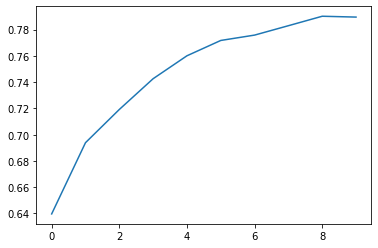

In [12]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
plt.plot([roc_auc_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

We observe that `roc_auc_score` still increases when the number of trees increases. Adding more trees improve the model.

## Adding more trees

In [13]:
m = RandomForestClassifier(n_estimators=20, n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 11.6 s, sys: 9.05 s, total: 20.6 s
Wall time: 3.37 s
[0.9043364324161944, 0.8348681583713486, 0.9734228734228734, 0.96954]


In [21]:
m = RandomForestClassifier(n_estimators=40, n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 47.7 s, sys: 24.9 s, total: 1min 12s
Wall time: 39.3 s
[0.9364281089936927, 0.8609290180259929, 0.9738909238909239, 0.96976]


In [28]:
m = RandomForestClassifier(n_estimators=80,n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 1min 8s, sys: 45.2 s, total: 1min 53s
Wall time: 44.3 s
[0.9529855542302128, 0.8737971297771846, 0.9742516742516742, 0.97038]


In [29]:
m = RandomForestClassifier(n_estimators=120,n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 1min 30s, sys: 1min 7s, total: 2min 37s
Wall time: 49.8 s
[0.9581467411876532, 0.8778753902848331, 0.9742738742738742, 0.9707]


In [30]:
m = RandomForestClassifier(n_estimators=180,n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 1min 58s, sys: 1min 36s, total: 3min 35s
Wall time: 57.1 s
[0.9611260518170784, 0.8814041041789905, 0.9743608243608244, 0.97028]


In [31]:
m = RandomForestClassifier(n_estimators=280,n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 2min 51s, sys: 2min 23s, total: 5min 15s
Wall time: 1min 9s
[0.9637942261041458, 0.8852261731087566, 0.9743848743848744, 0.97046]


We see that the model still improves as we add more trees. However, the improving rate is flattened as the number of trees grows above 200. Also, adding more trees takes longer time to for the model to train.

## Varying min samples

We experiment with different value of `min_samples_leaf` to reduce overfitting in the model.

In [14]:
m = RandomForestClassifier(n_estimators=20, min_samples_leaf=3, n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 12 s, sys: 10.4 s, total: 22.4 s
Wall time: 3.5 s
[0.8997895053690199, 0.8614383969665582, 0.9728623228623229, 0.96988]


In [17]:
m = RandomForestClassifier(n_estimators=20, min_samples_leaf=5, n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 10.7 s, sys: 9.19 s, total: 19.8 s
Wall time: 3.19 s
[0.8947060212966227, 0.8655707552763667, 0.9718041218041218, 0.96938]


In [18]:
m = RandomForestClassifier(n_estimators=20, min_samples_leaf=10, n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 10.1 s, sys: 10.2 s, total: 20.2 s
Wall time: 3.3 s
[0.8879720693395681, 0.8712359595700174, 0.9711196211196211, 0.96896]


In [19]:
m = RandomForestClassifier(n_estimators=20, min_samples_leaf=25, n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 9.52 s, sys: 8.99 s, total: 18.5 s
Wall time: 3.07 s
[0.877389468314549, 0.8680856616658983, 0.9701853701853702, 0.96778]


In [20]:
m = RandomForestClassifier(n_estimators=20, min_samples_leaf=35, n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 9.07 s, sys: 8.97 s, total: 18 s
Wall time: 2.85 s
[0.8747136874472449, 0.8646869623112652, 0.9695582195582195, 0.96758]


## Varying max features

In [22]:
m = RandomForestClassifier(n_estimators=20, min_samples_leaf=10, max_features=0.5, n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 1min 44s, sys: 8.86 s, total: 1min 53s
Wall time: 16.9 s
[0.9010849723786163, 0.8729833273512171, 0.9732508232508232, 0.97052]


In [23]:
m = RandomForestClassifier(n_estimators=20, min_samples_leaf=10, max_features=1.0, n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 3min 26s, sys: 7.87 s, total: 3min 34s
Wall time: 32.8 s
[0.9029309090375652, 0.8703599951072958, 0.9731786731786731, 0.9706]


In [24]:
m = RandomForestClassifier(n_estimators=20, min_samples_leaf=10, max_features="log2", n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 6.03 s, sys: 8.31 s, total: 14.3 s
Wall time: 2.41 s
[0.8691936890994235, 0.8607799256235259, 0.9701243201243201, 0.96786]


## Interpreting Models

Turn into numpy array for faster training

In [14]:
X_train = np.array(X_train, dtype=np.float32)

In [21]:
m = RandomForestClassifier(n_estimators=20, min_samples_leaf=10,max_features=0.5, n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 26.2 s, sys: 9.29 s, total: 35.5 s
Wall time: 6.9 s
[0.9296459178611897, 0.8714661328899901, 0.9747400747400747, 0.97058]


Start interpretation

In [10]:
set_rf_samples(50000)

In [17]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 20 ms, sys: 752 ms, total: 772 ms
Wall time: 10.8 s


(0.05, 0.21794494717703367)

In [18]:
raw_train, raw_valid = split_vals(train_merged, n_trn)

In [15]:
fi = rf_feat_importance(m, df); fi[:10]

,cols,imp
296,V258,0.085908
295,V257,0.053352
16,C1,0.046582
29,C14,0.035095
28,C13,0.028784
27,C12,0.025144
2,TransactionAmt,0.024438
227,V189,0.023425
284,V246,0.022713
4,card1,0.019993


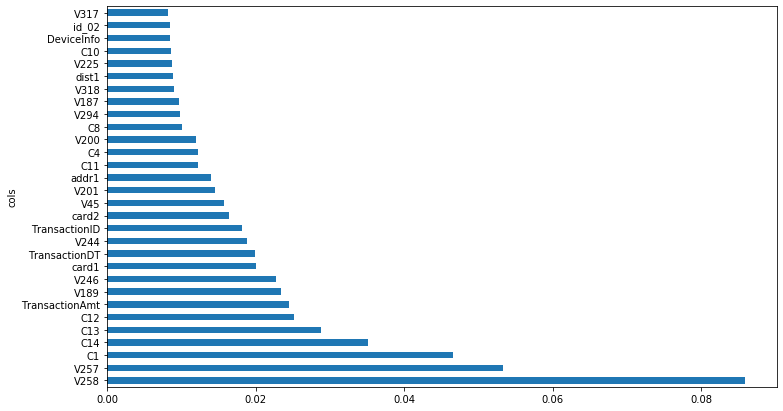

In [16]:
def plot_fi(fi): 
  return fi.plot('cols','imp','barh', figsize=(12,7), legend=False)
plot_fi(fi[:30]);

In [22]:
to_keep = fi[fi.imp>0.001].cols; len(to_keep)

139

In [23]:
df_keep = df[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)
X_train.shape, y_train.shape, X_valid.shape

((540540, 139), (540540,), (50000, 139))

In [24]:
m = RandomForestClassifier(n_estimators=20, min_samples_leaf=10,max_features=0.5,n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 1min, sys: 11.3 s, total: 1min 11s
Wall time: 15.5 s
[0.9345662340499425, 0.8810859753322793, 0.975012025012025, 0.97054]


# Official Training

In [25]:
reset_rf_samples()

In [7]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()
n_valid = 50000  # new validation set
n_trn = len(train_merged)-n_valid
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((540540, 1072), (540540,), (50000, 1072))

In [26]:
m = RandomForestClassifier(n_estimators=1000, min_samples_leaf=10,max_features=0.5,n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 7h 35min 45s, sys: 7min 5s, total: 7h 42min 50s
Wall time: 58min 11s
[0.9956276666635433, 0.9090622085691971, 0.9822325822325823, 0.97262]


# Testing and Submit to Kaggle

In [28]:
test_merged = pd.read_feather('tmp/IEEE-test-merged2')

In [29]:
test_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506691 entries, 0 to 506690
Columns: 613 entries, TransactionID to DeviceInfo
dtypes: bool(90), category(31), float64(474), int64(18)
memory usage: 1.9 GB


Use random forest model

In [31]:
X_test, _, nas = proc_df(test_merged, na_dict=nas)

In [34]:
X_test_keep = X_test[to_keep].copy()

In [35]:
X_test_keep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506691 entries, 0 to 506690
Columns: 139 entries, V258 to M9
dtypes: bool(1), float64(118), int16(3), int64(4), int8(13)
memory usage: 481.3 MB


In [32]:
df, y, nas = proc_df(train_merged, 'isFraud', na_dict=nas)

In [36]:
prediction = m.predict_proba(X_test_keep)

In [37]:
prediction[:5,1]

array([0.00694, 0.01028, 0.03882, 0.02068, 0.01608])

In [16]:
submission = pd.DataFrame()
submission['TransactionID'] = test_merged.TransactionID
submission['isFraud'] = prediction[:,1]

In [17]:
submission.shape

(506691, 2)

In [18]:
submission.to_csv('submission_2.csv',index=Faslse)

In [19]:
import pickle

In [21]:
filename = 'model_09.sav'
pickle.dump(m, open(filename, 'wb'))